In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import *
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import csv


Load the latest Urban areas data set with ACS demographics data. Use raw station count as the labels and run Boruta python package (with Random Forest regressor) to explore the feature space to identify all relevant features toward a 'minimal optimal' model.

In [51]:
# use boruta_py as a more generic way for feature selection of the modeling
import pandas as pd
from pandas import DataFrame, read_csv

import boruta_py

# read the entire initial urban areas data without pre-processing
df=pd.read_csv("data/initial_data_urban_area.csv")

# list(df.columns.values)
# drop irrelevant columns
df = df.drop('UANUM', 1).drop('UANAME', 1).drop('UANAME_LONG', 1)
df = df.drop('PeoplePerStation', 1).drop('StationsPerPerson', 1).drop('State', 1).drop('Geography', 1)
df = df.drop('Latitude', 1).drop('Longitude', 1)

# print len(df)
# list(df.columns.values)

# drop irrelevant columns and keep columns based on results from Boruta and feature significance from previous models
# step (1) keep percent_own and drop owners, keep the 4 highest income brackets per Boruta
df = df.drop(df.columns[[6,7,8,9,10,11,12,13,14,15,16,17]], axis=1).drop('Owners',1)
# step (2) drop all columns for 18 - 24 years and aggregate populations for 25 years and over
df = df.drop(df.columns[[9,10,11,12,13,14,15,16,17,19,22,25]], axis=1)
# step (3) drop male 25-34,35-44, and associated educational columns
df = df.drop(df.columns[[16,18,19,20,22,24,25,26]], axis=1)
# step (4) drop all 45-64, 65+ columns
df = df.drop(df.columns[[19,20,21,22,23,24,25,26,27,28,29,30]], axis=1)
# step (5) drop all median incomes for all age brackets
df = df.drop(df.columns[[19,20,21,22,23,24,25,26,27]], axis=1)
# step (6) drop aggregated education columns
df = df.drop(df.columns[[9,10,11,12,14]], axis=1)
list(df.columns.values)
# print len(df)

['StationCount',
 'IncentivesCount',
 'Population',
 'Households',
 'percent_own',
 'Household Income $100,000 to $124,999',
 'Household Income $125,000 to $149,999',
 'Household Income $150,000 to $199,999',
 'Household Income $200,000 or more',
 "Total; Estimate; Percent bachelor's degree or higher",
 'Total; Estimate; Population 25 to 34 years',
 'Female; Estimate; Population 25 to 34 years',
 'Total; Estimate; Population 35 to 44 years',
 'Female; Estimate; Population 35 to 44 years',
 'graduate_25+']

In [53]:
# drop missing values but keep zero station counts for modeling
df=df.dropna()
# print len(df) - no missing values for the selected features

# select X and y from the dataframe
ndata = df.values
ndata = np.hsplit(ndata, np.array([1]))
Y = ndata[0]
# flatten label from 1d array to (n_features,)
Y=np.ravel(Y)
X = ndata[1]
# print X[0], Y[0]

# shuffle and split
from sklearn.utils import shuffle

# shuffle two arrays in unison
X, Y = shuffle(X, Y, random_state=0)
# print Y
print Y.shape, X.shape

# Split the imported data into training 75% and development data 25%
split = 3*len(X)/4

# print len(X), split

train_data, train_labels = X[:split], Y[:split]
dev_data, dev_labels = X[split:], Y[split:]

# feature names
feaname = list(df.columns.values[1:])
print feaname

[  1.00000000e+00   1.98240000e+04   7.52900000e+03   6.41253819e+01
   3.91000000e+02   2.15000000e+02   2.02000000e+02   1.13000000e+02
   1.14000000e+01   2.64400000e+03   1.36500000e+03   2.17800000e+03
   1.09500000e+03   2.83162000e+02] 0.0
(3592,) (3592, 14)
['IncentivesCount', 'Population', 'Households', 'percent_own', 'Household Income $100,000 to $124,999', 'Household Income $125,000 to $149,999', 'Household Income $150,000 to $199,999', 'Household Income $200,000 or more', "Total; Estimate; Percent bachelor's degree or higher", 'Total; Estimate; Population 25 to 34 years', 'Female; Estimate; Population 25 to 34 years', 'Total; Estimate; Population 35 to 44 years', 'Female; Estimate; Population 35 to 44 years', 'graduate_25+']


Load merged data file with charging stations and ACS data aggregated by urban areas. Use raw count of stations as the labels (for now) and picked 10 attributes for modeling.Preprocessed the data into a csv file.

In [2]:
#import the processed urban area charging stations and ACS data with 10 selected covariates
# we pre-selected incentive, population, households, %owning houses, households $150-200K
# households >$200K, total college grads, total graduate degree, % college grads, median income as covariates
X = np.loadtxt("data/parsed_urban_area_data_10.csv",delimiter = ',',usecols = (1,2,3,4,5,6,7,8,9,10)) 
#X = np.loadtxt("data/parsed_urban_area_data.csv",delimiter = ',',usecols = (1,3,4,5,6,7,8,9,10))
# Above line of code removes population and we reran all the models. e.g., LinReg: score went up from 0.71 to 0.77
# indicative of our results were stable and robust so more confident to use raw station count as outcome variable
# labels. For now, we use station count
Y = np.loadtxt("data/parsed_urban_area_data_10.csv",delimiter = ',',usecols = (0,),dtype=float)  
# feature names
feaname = ["Incentive","Population","Households","% Owning Homes",
          "Households $150-200K","Households >$200K", "Total College Grads",
          "Total Graduate Degree","% College Grads","Median Income"] # feature names of the selected attributes

# checking input data and labels
print Y.shape, X.shape, len(X), X[4], Y[4]

# add shuffle code before splitting the data into train and dev sets
# easiest shuffle utility is sklearn shuffle function
from sklearn.utils import shuffle

# shuffle two arrays in unison
X, Y = shuffle(X, Y, random_state=0)
print Y.shape, X.shape, len(X), X[4], Y[4]
# double check the data type of the two arrays
print X.dtype, Y.dtype

# Split the imported data into training 75% and development data 25%

split = 3*len(X)/4

print len(X), split

train_data, train_labels = X[:split], Y[:split]
dev_data, dev_labels = X[split:], Y[split:]

print train_data.shape, train_labels.shape
print dev_data.shape, dev_labels.shape
print train_data[1], train_labels[1]
print dev_data[0], dev_labels[0]
# dev_dat=np.array(dev_data)
# print dev_dat.sum()
print feaname

(3590,) (3590, 10) 3590 [  0.00000000e+00   4.66600000e+03   1.79500000e+03   6.40668524e+01
   3.70000000e+01   1.60000000e+01   6.20000000e+00   6.40000000e+00
   1.51000000e+01   2.29230000e+04] 0.0
(3590,) (3590, 10) 3590 [  0.00000000e+00   1.65310000e+04   6.22000000e+03   6.48070740e+01
   9.80000000e+01   5.90000000e+01   1.20000000e+00   6.10000000e+00
   1.54000000e+01   2.80610000e+04] 0.0
float64 float64
3590 2692
(2692, 10) (2692,)
(898, 10) (898,)
[  1.00000000e+00   1.08350000e+04   4.37900000e+03   5.04224709e+01
   4.20000000e+01   1.02000000e+02   4.70000000e+00   8.80000000e+00
   1.93000000e+01   3.17510000e+04] 0.0
[  1.00000000e+00   5.19600000e+03   1.93300000e+03   5.91826177e+01
   1.80000000e+01   1.30000000e+01   3.00000000e-01   6.10000000e+00
   1.40000000e+01   2.05180000e+04] 0.0
['Incentive', 'Population', 'Households', '% Owning Homes', 'Households $150-200K', 'Households >$200K', 'Total College Grads', 'Total Graduate Degree', '% College Grads', 'Media

In [3]:
# import the processed urban area charging stations and ACS data with 25 covariates
# only three rows that have missing vaules for the 25 covariates so we will not treat missing values separately
# if there were more missing values, we could use the sklearn feature (link below) to extrapolate and replace NA's
# http://stackoverflow.com/questions/30317119/classifiers-in-scikit-learn-that-handle-nan-null?lq=1

# load input vectors for the 25 covariates
X = np.loadtxt("data/parsed_urban_area_data_25.csv",delimiter = ',',usecols = (1,2,3,4,5,6,7,8,9,10,11,12,13,
                                                                              14,15,16,17,18,19,20,21,22,23,24,25)) 
# load labels, i.e., station counts
Y = np.loadtxt("data/parsed_urban_area_data_25.csv",delimiter = ',',usecols = (0,),dtype=float)  

# feature names for 25 pre-selected covariates
feaname = ["Incentive","Population","Households","% Owning Homes",
            "Households $50-60K","Households $60-75K","Households $75-100K",
           "Households $100-124K","Households $125-150K",
          "Households $150-200K","Households >$200K", "Total College Grads",
          "Total Graduate Degree","% College Grads",
           "Pop 18-24","Female 18-24","Pop 25-34","Female 25-34","Pop 35-44","Female 35-44",
           "Pop 45-64","Female 45-64","Pop >65","Female >65",
           "Median Income"] # feature names of the selected attributes

# checking input data and labels
print Y.shape, X.shape, len(X), X[4], Y[4]

# shuffle X and Y before splitting the data into train and dev sets
# the easiest shuffle utility is the sklearn shuffle function
from sklearn.utils import shuffle

# shuffle inputs and labels in unison
X, Y = shuffle(X, Y, random_state=0)

# print Y.shape, X.shape, len(X), X[4], Y[4]
# double check the data type of the two arrays
print X.dtype, Y.dtype

# Split the imported data into training 75% and development data 25%
# results should not be sensitive to how data is split

split = 3*len(X)/4

print len(X), split

train_data, train_labels = X[:split], Y[:split]
dev_data, dev_labels = X[split:], Y[split:]

print train_data.shape, train_labels.shape
print dev_data.shape, dev_labels.shape
# print train_data[1], train_labels[1]
# print dev_data[0], dev_labels[0]
# dev_dat=np.array(dev_data)
# print dev_dat.sum()
print feaname

(3590,) (3590, 25) 3590 [  0.00000000e+00   4.66600000e+03   1.79500000e+03   6.40668524e+01
   1.77000000e+02   7.10000000e+01   7.30000000e+01   7.00000000e+01
   8.00000000e+00   3.70000000e+01   1.60000000e+01   6.20000000e+00
   6.40000000e+00   1.51000000e+01   4.86000000e+02   3.48000000e+02
   4.29000000e+02   1.96000000e+02   5.57000000e+02   3.34000000e+02
   1.31500000e+03   7.29000000e+02   7.74000000e+02   4.81000000e+02
   2.29230000e+04] 0.0
float64 float64
3590 2692
(2692, 25) (2692,)
(898, 25) (898,)
['Incentive', 'Population', 'Households', '% Owning Homes', 'Households $50-60K', 'Households $60-75K', 'Households $75-100K', 'Households $100-124K', 'Households $125-150K', 'Households $150-200K', 'Households >$200K', 'Total College Grads', 'Total Graduate Degree', '% College Grads', 'Pop 18-24', 'Female 18-24', 'Pop 25-34', 'Female 25-34', 'Pop 35-44', 'Female 35-44', 'Pop 45-64', 'Female 45-64', 'Pop >65', 'Female >65', 'Median Income']


('Coefficients: \n', array([  1.22185212e-01,  -1.08677847e-04,  -2.44257431e-04,
        -3.01611062e-03,   3.30652368e-03,  -1.75086463e-03,
        -3.21878282e-03,  -2.00593877e-03,   2.34665939e-02,
         4.90070696e-03,  -1.17467843e-02,   6.55329537e-03,
        -8.73388241e-03,   1.71565162e-03]))
Variance score: 0.59
(898,) (898,)
0.0 348.0 -16.8294895337 479.720020307 -21.0125867874 773.768874009


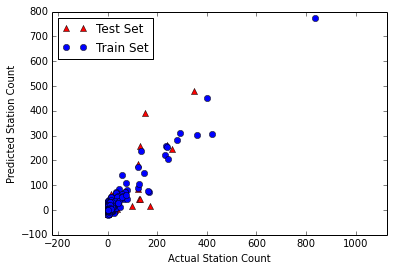

In [45]:
# try lineary regression mode
from sklearn import datasets, linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_data, train_labels)

# The coefficients
print('Coefficients: \n', regr.coef_)

# score
print('Variance score: %.2f' % regr.score(dev_data, dev_labels))

# predict the dev data set
dev_predictions=regr.predict(dev_data)
print dev_predictions.shape, dev_labels.shape
train_predict = regr.predict(train_data)
# print dev_predictions[0], dev_labels[0]
print np.amin(dev_labels), np.amax(dev_labels), np.amin(dev_predictions), np.amax(dev_predictions), np.amin(train_predict), np.amax(train_predict)


# visualize predicted vs actual labels
# plt.axis([-40, 850, -40, 850])
plt.axis('equal')
red_tri, = plt.plot(dev_labels, dev_predictions, 'r^', label='Test Set')
blue_cir, = plt.plot(train_labels, train_predict, 'bo', label='Train Set')
plt.ylabel('Predicted Station Count')
plt.xlabel('Actual Station Count')
plt.legend(loc=2)
plt.show()

Interpretation of the Linear Regression model: TBD.

(898, 71) (898,)
0.708240534521
(898,) (898,)
0.0 361.0 0.0 123.0 0.0 835.0


/Library/Python/2.7/site-packages/sklearn/linear_model/base.py:239: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


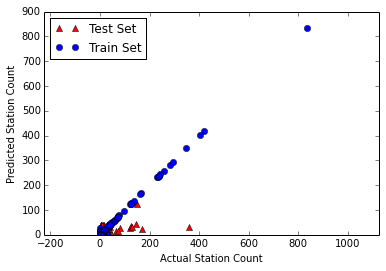

In [35]:
# model with logistic regression 
#
logreg = LogisticRegression(penalty='l1', C=1.0, tol=0.01) 
logreg.fit(train_data, train_labels)

# examine predict prob for test data
print logreg.predict_proba(dev_data).shape, dev_labels.shape

# coeff_ for predictor, e.g., 0th=incentive, 1st=pop, 2nd=household, 3rd=%owning home, etc
# vs labels - 0th =0 charging station, 1st =1 charging station etc....
# print('Incentive Count vs Count of Charging Stations: \n', np.transpose(logreg.coef_)[0])

# print('Home Ownership Percentage vs Count of Charging Stations: \n', np.transpose(logreg.coef_)[2])

# examine score for test data
print logreg.score(dev_data, dev_labels)

# predict the dev data set
dev_predictions=logreg.predict(dev_data)
print dev_predictions.shape, dev_labels.shape
train_predict = logreg.predict(train_data)
# print dev_predictions[0], dev_labels[0]
print np.amin(dev_labels), np.amax(dev_labels), np.amin(dev_predictions), np.amax(dev_predictions), np.amin(train_predict), np.amax(train_predict)


# visualize predicted vs actual labels
# plt.axis([-40, 850, -40, 850])
plt.axis('equal')
red_tri, = plt.plot(dev_labels, dev_predictions, 'r^', label='Test Set')
blue_cir, = plt.plot(train_labels, train_predict, 'bo', label='Train Set')
plt.ylabel('Predicted Station Count')
plt.xlabel('Actual Station Count')
plt.legend(loc=2)
plt.show()


Logistic Regression showed very similar score of 71% to the linear regression for test data set. Prediction for test set was much worse than by linear regression and tend to underpredict the outcome. The best explanation I can come up with is that it appears logistic regression somehow overfitted the training set especially for the urban areas with many charging stations.

0.867519950787


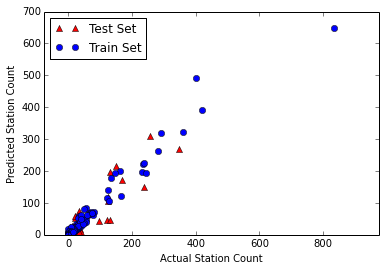

0.867521869361 1.79995545657 57.7070244989 0.867519950787
1. feature 7  Household Income $200,000 or more (0.254285)
2. feature 13  graduate_25+ (0.168234)
3. feature 9  Total; Estimate; Population 25 to 34 years (0.148391)
4. feature 6  Household Income $150,000 to $199,999 (0.095951)
5. feature 3  percent_own (0.083892)
6. feature 11  Total; Estimate; Population 35 to 44 years (0.077262)
7. feature 5  Household Income $125,000 to $149,999 (0.054565)
8. feature 4  Household Income $100,000 to $124,999 (0.038947)
9. feature 8  Total; Estimate; Percent bachelor's degree or higher (0.029016)
10. feature 10  Female; Estimate; Population 25 to 34 years (0.024649)
11. feature 2  Households (0.013524)
12. feature 1  Population (0.006035)
13. feature 0  IncentivesCount (0.004173)
14. feature 12  Female; Estimate; Population 35 to 44 years (0.001076)


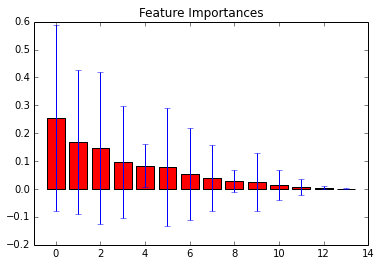

In [55]:
# random forest modeling

random = RandomForestRegressor(n_estimators=50)
random.fit(train_data, train_labels)

# Make predictions on dev data
dev_predictions = random.predict(dev_data)
# Predict train data to examine if model overfitted
train_predict = random.predict(train_data)

# examine score for test data
print random.score(dev_data, dev_labels)

# visualize predicted vs actual labels
# plt.axis([-40, 850, -40, 850])
plt.axis('equal')
red_tri, = plt.plot(dev_labels, dev_predictions, 'r^', label='Test Set')
blue_cir, = plt.plot(train_labels, train_predict, 'bo', label='Train Set')
plt.ylabel('Predicted Station Count')
plt.xlabel('Actual Station Count')
plt.legend(loc=2)
plt.show()

_explained_variance_score = explained_variance_score(dev_labels, dev_predictions)
_mean_absolute_error = mean_absolute_error(dev_labels, dev_predictions)
_mean_squared_error = mean_squared_error(dev_labels, dev_predictions)
_r2_score = r2_score(dev_labels, dev_predictions)

print _explained_variance_score, _mean_absolute_error, _mean_squared_error, _r2_score

# predicting charging station count for Coppell Texas
#X_Coppell=np.array([39551,0.488938333,37.9,22.1,64572,0.721044394])
# print random.predict(X_Coppell)

# evaluate the importances of the features
importances = random.feature_importances_
std = np.std([tree.feature_importances_ for tree in random.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]

max = len(feaname)
for f in range(max):
    print("%d. feature %d  %s (%f)" % ( f + 1, indices[f], feaname[indices[f]], importances[indices[f]]))

# plot the feature importances
plt.figure()
plt.title("Feature Importances")
plt.bar(range(max), importances[indices], 
       color='r', yerr=std[indices], align="center")
plt.xlim([-1,max])
plt.show()

In [58]:
# predict charging station counts based on optimal Random Forest model above
Y_predict = random.predict(X)

X1=np.column_stack((Y_predict, Y, X))

np.savetxt('predicted_urban_areas_optimal_RF.csv', X1, fmt='%f',delimiter=',',newline='\n',header='',footer='')

0.72271714922


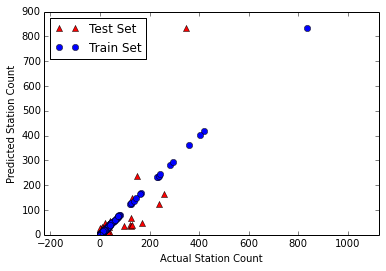

1. feature 13  graduate_25+ (0.078056)
2. feature 2  Households (0.076368)
3. feature 4  Household Income $100,000 to $124,999 (0.076359)
4. feature 1  Population (0.075455)
5. feature 5  Household Income $125,000 to $149,999 (0.074853)
6. feature 10  Female; Estimate; Population 25 to 34 years (0.074559)
7. feature 6  Household Income $150,000 to $199,999 (0.074156)
8. feature 8  Total; Estimate; Percent bachelor's degree or higher (0.073790)
9. feature 7  Household Income $200,000 or more (0.073245)
10. feature 11  Total; Estimate; Population 35 to 44 years (0.072040)
11. feature 9  Total; Estimate; Population 25 to 34 years (0.071023)
12. feature 12  Female; Estimate; Population 35 to 44 years (0.068046)
13. feature 3  percent_own (0.061510)
14. feature 0  IncentivesCount (0.050541)


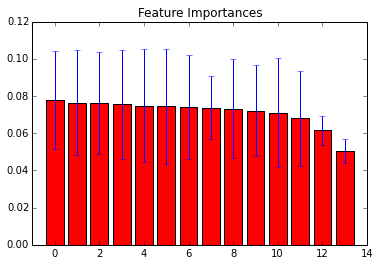

In [57]:
# try to rank importance of features from 250 Decision Trees 
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
# fit the whole data set and calcualte feature importances
forest.fit(train_data, train_labels)

# Make predictions on dev data
dev_predictions = forest.predict(dev_data)
# Predict train data to examine if model overfitted
train_predict = forest.predict(train_data)

# examine score for test data
print forest.score(dev_data, dev_labels)

# visualize predicted vs actual labels
# plt.axis([-40, 850, -40, 850])
plt.axis('equal')
red_tri, = plt.plot(dev_labels, dev_predictions, 'r^', label='Test Set')
blue_cir, = plt.plot(train_labels, train_predict, 'bo', label='Train Set')
plt.ylabel('Predicted Station Count')
plt.xlabel('Actual Station Count')
plt.legend(loc=2)
plt.show()

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]

max=len(feaname)
for f in range(max):
    print("%d. feature %d  %s (%f)" % ( f + 1, indices[f], feaname[indices[f]], importances[indices[f]]))

# plot the feature importances
plt.figure()
plt.title("Feature Importances")
plt.bar(range(max), importances[indices], 
       color='r', yerr=std[indices], align="center")
plt.xlim([-1,max])
plt.show()

In [8]:
# import pandas
# to do's Friday night - use case - predict the most potential urban areas for EV adoption or growth
# use the best model - random forest model with the 10 attributes to:
# predict top urban area EV pravalence or CS counts
# write the predicted CS counts with numpy savetxt() - add a new column "Predicted Station Count"
# merge with the unparsed data with long/lat data 
# sort based on the difference of predicted versus actual counts
# the bigger the predicted - actual, the more potential there is for the urban area to adopt EV
# 
#reload all parsed urban area data with the same selected attributes as the first part of the modeling
X = np.loadtxt("data/parsed_urban_area_data_25.csv",delimiter = ',',usecols = (1,2,3,4,5,6,7,8,9,10,
                                                                              11,12,13,14,15,16,17,
                                                                              18,19,20,21,22,23,24,25)) 
# reload the actual labels
Y_actual = np.loadtxt("data/parsed_urban_area_data_25.csv",delimiter = ',',usecols = (0,),dtype=float)  

# predict charging station counts based on Random Forest model previously
Y_predict = random.predict(X)

# print X.shape, Y_actual.T.shape, Y_predict.T.shape

X1=np.column_stack((Y_predict, Y_actual, X))
# print X1

np.savetxt('predicted_urban_areas_25.csv', X1, fmt='%f',delimiter=',',newline='\n',header='',footer='')



In [9]:
# attempt to use boruta_py as a more generic way for feature selection of the modeling
import pandas
#import numpy
#print numpy.__version__
#from numpy import (nansum, nanmean, nanstd, nanvar, nanmin, nanmax, median,nanmedian)
import boruta_py

# take the default parameters for RandomForestRegressor
random = RandomForestRegressor()

# define Boruta feature selection method
feat_selector = boruta_py.BorutaPy(random, n_estimators='auto', verbose=2)

# find all relevant features
feat_selector.fit(X, Y)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	12
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	12
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	12
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	12
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	11
Rejected: 	9
I

array([16, 17, 11,  1,  5, 13,  5,  1,  1,  1,  1, 14,  2, 12,  5, 15,  1,
        2,  1,  8,  8,  3, 10, 18,  8])

In [11]:
print feaname

['Incentive', 'Population', 'Households', '% Owning Homes', 'Households $50-60K', 'Households $60-75K', 'Households $75-100K', 'Households $100-124K', 'Households $125-150K', 'Households $150-200K', 'Households >$200K', 'Total College Grads', 'Total Graduate Degree', '% College Grads', 'Pop 18-24', 'Female 18-24', 'Pop 25-34', 'Female 25-34', 'Pop 35-44', 'Female 35-44', 'Pop 45-64', 'Female 45-64', 'Pop >65', 'Female >65', 'Median Income']


In [9]:
# use boruta_py as a more generic way for feature selection of the modeling
import pandas as pd
from pandas import DataFrame, read_csv

import boruta_py

# read the entire initial urban areas data without pre-processing
df=pd.read_csv("data/initial_data_urban_area.csv")

# list(df.columns.values)
# drop irrelevant columns
df = df.drop('UANUM', 1).drop('UANAME', 1).drop('UANAME_LONG', 1).drop('PeoplePerStation', 1).drop('StationsPerPerson', 1).drop('State', 1).drop('Geography', 1).drop('Latitude', 1).drop('Longitude', 1)

# print len(df)
# list(df.columns.values)

# drop missing values but keep zero station counts for modeling
df=df.dropna()
# print len(df)

# select X and y from the dataframe
ndata = df.values
ndata = np.hsplit(ndata, np.array([1]))
Y = ndata[0]
Y=np.ravel(Y)
X = ndata[1]
# print X.shape, Y.shape

# shuffle and split
from sklearn.utils import shuffle

# shuffle two arrays in unison
X, Y = shuffle(X, Y, random_state=0)
# print Y
# print Y.shape, X.shape

# Split the imported data into training 75% and development data 25%
split = 3*len(X)/4

# print len(X), split

train_data, train_labels = X[:split], Y[:split]
dev_data, dev_labels = X[split:], Y[split:]

# print train_data.shape, train_labels.shape, dev_data.shape, dev_labels.shape

# take the default parameters for RandomForestRegressor
random = RandomForestRegressor()

# define Boruta feature selection method
feat_selector = boruta_py.BorutaPy(random, n_estimators='auto', max_iter=30, verbose=2)

# find all relevant features
feat_selector.fit(X, Y)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_


Iteration: 	1 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	2 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	3 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	4 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	5 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	6 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	7 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	8 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	9 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	10 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	11 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	12 / 30
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	13 / 30
Confirmed: 	7
Tentative: 	21
Rejected: 	45
Iteration: 	14 / 30
Confirmed: 	7
Tentative: 	21
Rejected: 	45
Iteration: 	15 / 30
Confirmed: 	7
Tentative: 	21
Rejected: 	45
Iteration: 	16 / 30
Confirmed: 	7
Tentative: 	21
Rejected: 	45
Iteration: 	1

array([50, 20, 30, 60,  3, 22, 31, 64, 52, 58, 17, 17, 35, 26, 11, 12, 20,
        2,  1,  1,  1,  6,  4, 47, 55, 60,  8,  5, 14,  8, 43, 38, 38, 14,
       14, 45, 65, 64, 50,  1,  1,  3, 61, 43, 58,  2,  1, 18, 25, 38, 24,
        8, 10, 62, 27, 24, 45, 56, 21, 36, 41, 54, 35, 29, 33, 48, 29, 33,
       53, 41, 52, 47,  1])